EVALUATION METRICS: https://www.analyticsvidhya.com/blog/2019/08/11-important-model-evaluation-error-metrics/

F1 Score = ( ( precision * recall ) / ( ( beta^2 * precision) + recall ) ) * (1 - beta^2)

Precision and Recall: Precision (also called positive predictive value) is the fraction of relevant instances among the retrieved instances, while recall (also known as sensitivity) is the fraction of relevant instances that were retrieved. Both precision and recall are therefore based on relevance.

https://en.wikipedia.org/wiki/Precision_and_recall

!!! https://en.wikipedia.org/wiki/Confusion_matrix

In [13]:
#this is needed for correct module importing
%cd /Users/paolobonomi/Work/Python/CapsNetwork
import sys
sys.path.append("/Users/paolobonomi/Work/Python/CapsNetwork/src")

import numpy as np
from numpy import sqrt 

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from model_10_epochs import model, testing, dataset, training_dataset_size, testing_dataset_size
from capsuleNetwork import CapsuleNetwork

/Users/paolobonomi/Work/Python/CapsNetwork


In [204]:
headers = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
decimals = 3

def get_confusion_table_for(mat, digit, tot):
    
    dict_ = {}
    
    # condition positive (how many images were < digit >)
    p = 0
    for i in range(0, 10):
        p += mat[i, digit]
    dict_["Condition Positive"] = p
    
    #condition negative (how many images were not < digit > )
    n = tot - p
    dict_["Condition Negative"] = n 
    
    tp = mat[digit, digit]
    dict_["True Positive (TN)"] = tp
    
    fn = -tp
    for i in range(0, 10):
        fn += mat[i, digit]
    dict_["False Negative (FN)"] = fn
    
    fp = -tp
    for i in range(0, 10):
        fp += mat[digit, i]
    dict_["False Positive (FP)"] = fp 
    
    tn = tot + tp    
    for i in range(0, 10):
        tn -= mat[digit, i] + mat[i, digit]
    dict_["True Negative (TN)"] = tn 

    tpr = tp / p
    dict_["Sensitivity (TPR)"] = tpr 

    tnr = tn / n
    dict_["Specificity (TNR)"] = tnr 

    ppv = tp / (tp + fp)
    dict_["Positive Predictive Value (PPV)"] = ppv

    npv = tn / ( tn + fn )
    dict_["Negative Predictive Value (NPV)"] = npv 

    fnr = 1 - tpr
    dict_["False Negative Rate (FNR)"] = fnr 

    fpr = 1 - tnr
    dict_["False Positive Rate (FPR)"] = fpr 

    fdr = 1 - ppv
    dict_["False Discovery Rate (FDR)"] = fdr 

    for_ = 1 - npv
    dict_["False Omission Rate (FOR)"] = for_ 

    lr_p = tpr/fpr
    dict_["Positive Likelihood Ratio (LR+)"] = int(lr_p) 
    
    lr_n = fnr/tnr
    dict_["Negative Likelihood Ratio (LR-)"] = lr_n 

    pt = sqrt( fpr ) / ( sqrt(tpr) * sqrt(fpr) )
    dict_["Prevalence Threshold (PT)"] = pt 

    ts = tp / ( tp + fn + fp )
    dict_["Threat Score"] = ts 

    prevalence = p / tot
    dict_["Prevalence"] = prevalence 
    
    acc = ( tp + tn ) / tot
    dict_["Accuracy (ACC)"] = acc 

    ba = ( tpr * tnr ) / 2
    dict_["Balanced Accuracy"] = ba 

    f1 = ( 2*tp ) / ( 2*tp + fp + fn )
    dict_["F1 Score"] = f1 

    mcc = ( ( tp * tn ) - ( fp * fn ) ) / sqrt( ( tp+fp )*( tp*fn )*( tn+fp )*(tn+fn) )
    dict_["Matthews Correlation Coefficient (MCC)"] = mcc
    
    fm = sqrt( ppv * tpr )
    dict_["Fowlkes–Mallows Index (FM)"] = fm
    
    bm = tpr + tnr - 1
    dict_["Bookmaker Informedness (BM)"] = bm
    
    mk = ppv + npv - 1
    dict_["Markedness (MK)"] = mk
    
    #from 0 to inf
    dor = lr_p / lr_n
    dict_["Diagnostic odds ratio (DOR)"] = int(dor)
    
    header = np.array(list(dict_.keys()))
    values = np.array(list(dict_.values()))
    
    return values, header

def get_accuracy(matrix):
    a = 0        
    for i in range(0, 10):        
        a += matrix[i, i]
    
    return a

def get_confusion_mat(model, data):
    matrix = np.zeros((10,10))

    for X_batch, y_batch in data:
        res = CapsuleNetwork.predict(model, X_batch)
        for i in range(0, y_batch.shape[0]):
            #      row       , col
            matrix[y_batch[i], res[i]] += 1

    return matrix

def normalize_matrix(matrix, tot):
    mat = matrix.copy()
    for i in range(0, 10):
        for j in range(0, 10):
            mat[i, j] = (mat[i, j] / tot) * 100  
    return mat

def print_eval_params(mat):
    
    tot_in = 0
    tot_out = 0
    
    for j in range(0, 10):
        digit = j
        
        v = 0
        for i in range(0, 10):
            v += mat[digit, i]
        k = mat[digit, digit]
        tot_out += (k/v)
        r = (k/v)*100
        
        
        #the model has predict digit v times, k of that was right
        #osservo l'output, qual'è la probabilità che il modello abbia classificato in modo corretto?
        print("Proportion of digit < "+str(digit)+" > that was correctly identified =\t\t"+str(r)+"%") #sommo sulla riga

        v = 0
        for i in range(0, 10):
            v += mat[i, digit]  
        k = mat[digit, digit]
        tot_in += (k/v)
        r = (k/v)*100
        
        #the environment has shown digit v times, the model has predicted it k times
        #osservo l'input, qual'è la probabilità che venga classificato correttamente? 
        print("Proportion of actual digit < "+str(digit)+" > which is correctly identified =\t"+str(r)+"%") #sommo sulla colonna
        
        print("")

    print("Average observation correctness respect to ouput = "+str(tot_out*10))
    print("Average observation correctness respect to input = "+str(tot_in*10))

def print_matrix(matrix, title, x_label, y_label, x_headers, y_headers, size_x=10, size_y=10, color="Blues"):
    fig, ax = plt.subplots(figsize=(size_x,size_y))
    ax = sns.heatmap(matrix, annot=True, fmt='g', cmap=color, ax=ax)
        
    ax.set_title(title+'\n\n', size=size_x*1.9);
    ax.set_xlabel('\n'+x_label, size=size_x*1.5)
    ax.set_ylabel(y_label+' \n', size=size_x*1.5);

    ##legend
    if normalize:
        colorbar = ax.collections[0].colorbar
        colorbar.set_ticks([0, 2, 4, 6, 8, 10])
        colorbar.set_ticklabels(['0%', '2%', '4%', '6%', '8%', '10%'])

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(x_headers)
    ax.yaxis.set_ticklabels(y_headers)

    ## Display the visualization of the Confusion Matrix.
    plt.show()
    
def trim(string):
    if string.endswith(".0"):
        return string[0:-2]
    return string
    
def print_confusion_tables(confusion_matrix, dataset_size):
    values = []
    index = []
    columns = []
    for i in range(0, 10):
        v, h = get_confusion_table_for(confusion_matrix, i, dataset_size)
        values.append(v)
        index = h
        columns.append(i)
    
    values = np.around(np.array(values), decimals=decimals)
    index = np.array(index)
    columns = np.array(columns)

    df = pd.DataFrame( values , index=columns, columns=index, dtype=str).T
    df.columns.name = "Digit"
    df = df.applymap(trim)
    return df 

# BINARY TABLE OF CONFUSION

https://en.wikipedia.org/wiki/Confusion_matrix

source

Sources: Fawcett (2006),[1] Piryonesi and El-Diraby (2020),[2] Powers (2011),[3] Ting (2011),[4] CAWCR,[5] D. Chicco & G. Jurman (2020, 2021),[6][7] Tharwat (2018).[8]

In [203]:
%store -r confusionmatrix_test   
    
print_confusion_tables(confusionmatrix_test, testing_dataset_size)

Digit,0,1,2,3,4,5,6,7,8,9
Condition Positive,991,1146,1038,996,967,894,952,1026,977,1013
Condition Negative,9009,8854,8962,9004,9033,9106,9048,8974,9023,8987
True Positive (TN),975,1129,1016,988,959,883,941,1008,966,991
False Negative (FN),16,17,22,8,8,11,11,18,11,22
False Positive (FP),5,6,16,22,23,9,17,20,8,18
True Negative (TN),9004,8848,8946,8982,9010,9097,9031,8954,9015,8969
Sensitivity (TPR),0.984,0.985,0.979,0.992,0.992,0.988,0.988,0.982,0.989,0.978
Specificity (TNR),0.999,0.999,0.998,0.998,0.997,0.999,0.998,0.998,0.999,0.998
Positive Predictive Value (PPV),0.995,0.995,0.984,0.978,0.977,0.99,0.982,0.981,0.992,0.982
Negative Predictive Value (NPV),0.998,0.998,0.998,0.999,0.999,0.999,0.999,0.998,0.999,0.998


# CONFUSION MATRIX TRAIN SET

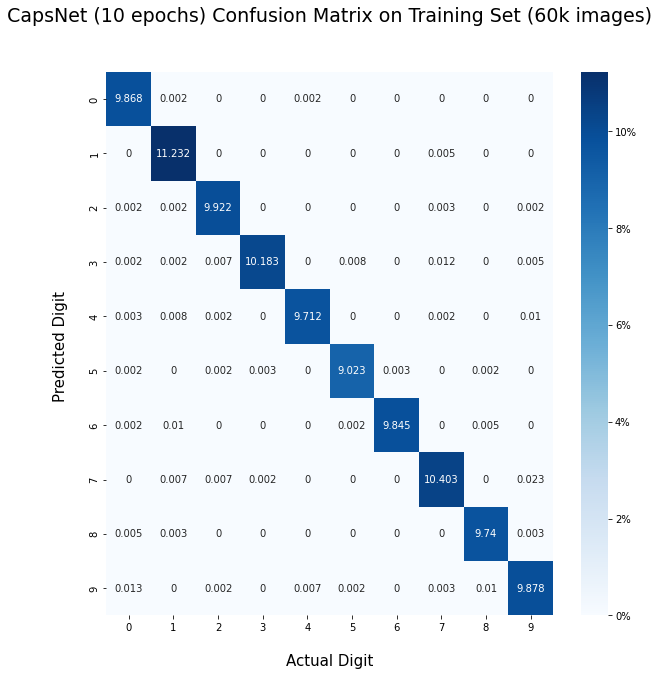

In [143]:
##

#confusionmatrix_train = get_confusion_matrix(model, dataset)

#%store confusionmatrix_train

%store -r confusionmatrix_train

print_matrix(
    np.around(normalize_matrix( confusionmatrix_train, training_dataset_size), decimals=decimals),
    'CapsNet (10 epochs) Confusion Matrix on Training Set ('+str(int(training_dataset_size/1000))+'k images)',
    'Actual Digit',
    'Predicted Digit',
    headers,
    headers)


# CONFUSION MATRIX TEST SET

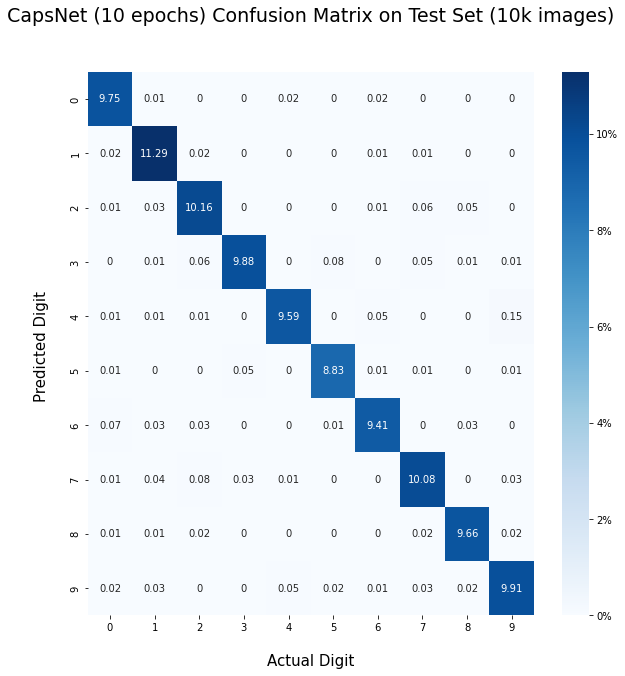

In [150]:
#confusionmatrix_test = get_confusion_matrix(model, testing)

#%store confusionmatrix_test

%store -r confusionmatrix_test

print_matrix( 
    np.around( normalize_matrix( confusionmatrix_test, testing_dataset_size), decimals=decimals ), 
    'CapsNet (10 epochs) Confusion Matrix on Test Set ('+str(int(testing_dataset_size/1000))+'k images)', 
    'Actual Digit', 
    'Predicted Digit', 
    headers, 
    headers) 

# MODEL ACCURACY

In [146]:
acc_train = get_accuracy(normalize_matrix( confusionmatrix_train, training_dataset_size))
acc_test = get_accuracy(normalize_matrix( confusionmatrix_test, testing_dataset_size))
d = {
    "Accuracy" : [np.around(acc_train, decimals=decimals), np.around(acc_test, decimals=decimals)],
    "# Images" : [training_dataset_size, testing_dataset_size],
    "Epochs" : [10, 10]
}
df = pd.DataFrame(d, index=["Train", "Test"])

In [147]:
df

,Accuracy,# Images,Epochs
Train,99.807,60000,10
Test,98.560,10000,10
